# My Tokenizer

In [1]:
import os
import time
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset

#%matplotlib inline


# import the right version of tqdm for where we are running
try:
    env_type = get_ipython().__class__.__name__ 
except NameError:
    env_type = 'terminal'
if env_type == 'ZMQInteractiveShell':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

if torch.cuda.is_available():
    torch.set_default_device('cuda')
# Force cpu because it's much faster than mps.
# I have no ide why, but such is life.
#elif torch.backends.mps.is_available():
#    torch.set_default_device('mps')
else:
    torch.set_default_device('cpu')

## Config and constants

In [2]:
vocab_file: str = "vocab.txt"  # path to output vocab file
overwrite: bool = True  # overwrite existing vocab file
max_vocab_size: int = 10_000  # maximum size of vocab
max_token_length: int = 40  # maximum length of token
random_seed = 42

#max_examples = 36_718
max_examples = 100

if not overwrite:
    assert not os.path.exists(vocab_file), f"{vocab_file} already exists"
assert max_vocab_size > 0, f"max_vocab_size must be positive, got {max_vocab_size}"
assert max_token_length > 0, f"max_token_length must be positive, got {max_token_length}"
max_entropy = float(np.log2(max_vocab_size))


## Load dataset to calculate token frequencies 

In [3]:

# ds_full = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
ds_full = load_dataset("graelo/wikipedia", "20230901.en", split="train")
dl_full = ds_full.to_iterable_dataset().shuffle(seed=random_seed, buffer_size=10_000)

ds = []
with tqdm(total=max_examples, desc="loading dataset", unit='example') as pb:
    for i, ex in enumerate(dl_full):
        if i >= max_examples:
            break
        ds.append(bytes(ex['text'], 'utf-8'))
        pb.update(1)
        pb.refresh()

assert len(ds) == max_examples, f"expected {max_examples} examples, got {len(ds)}"


loading dataset:   0%|          | 0/100 [00:00<?, ?example/s]

## Helper functions

In [4]:
def normalize(c, dim=None):
    """Converts a Counter or dict to a probability distribution"""
    if isinstance(c, (dict, Counter)):
        total = sum(c.values())
        p = {k: v / total for k, v in c.items()}
    else:
        p = torch.tensor(c)
        p = p / p.sum(dim=dim, keepdim=True)
    return p
    
def entropy(c, dim=None, keepdim=False):
    """Computes the entropy of a Counter or dict"""
    p = normalize(c, dim=dim)
    if isinstance(c, (dict, Counter)):
        p = torch.tensor(list(p.values()))
    p = p[p > 0]
    return -torch.sum(p * torch.log2(p).nan_to_num(), dim=dim, keepdim=keepdim)

def make_inital_vocab(ds=ds):
    """Creates an initial vocab from a dataset"""
    c = Counter({bytes([i]):0 for i in range(256)})
    for example in tqdm(ds, desc=f"finding all 1-byte token frequencies", smoothing=0, unit="example", leave=True):
        for i in example:
            #assert isinstance(i, int) and i <256, f"expected 1-byte tokens, got {repr(i)}"
            c.update({bytes([i]): 1 })
            #c[bytes([i])] = c.get(bytes([i]), 0) + 1
    return c

def get_freqs(tokens, ds=ds, progress=False):
    """Finds the frequency of each token in tokens in the dataset ds"""
    #tqdm.write(f"finding frequency of {len(tokens)} tokens...")
    freqs = defaultdict(int)
    if progress:
        ds = tqdm(ds, total=len(ds), desc=f"finding frequency of {len(tokens):,} tokens", smoothing=0, unit="example")
    for ex in ds:
        for t in tokens:
            freqs[t] += ex.count(t)
    return freqs

def find_best_merge(all_tokens, all_freqs, a_token, b_tokens, b_freqs, merge_tokens, merge_freqs):
    """Finds the best b_token to merge with a given a_token to maximize the entropy of the frequencies of the resulting token set"""
    all_freqs = torch.tensor(all_freqs) 
    merge_freqs = torch.tensor(merge_freqs)

    freqs_t = normalize(all_freqs).unsqueeze(0) * torch.ones(len(merge_freqs), len(all_freqs))
    freqs_t = torch.cat([freqs_t, merge_freqs.unsqueeze(1)], dim=1)
    assert freqs_t.shape == (len(merge_freqs), len(all_freqs)+1), f"{len(all_freqs)+1=}, {freqs_t.shape=}, {len(merge_freqs)=} {merge_freqs.unsqueeze(0).shape=}"
    at_idx = torch.tensor([all_tokens.index(a_token)])
    freqs_t[:, at_idx] = freqs_t[:, at_idx] - merge_freqs.unsqueeze(1)
    bt_idxes = torch.tensor([all_tokens.index(bt) for bt in b_tokens])
    freqs_t[:, bt_idxes] = freqs_t[:, bt_idxes] - merge_freqs.unsqueeze(1)
    #for m_idx, (bt, bf, mt, mf) in enumerate(zip(b_tokens, b_freqs, merge_tokens, merge_freqs)):
    #    bt_idx = all_tokens.index(bt)
    #    freqs_t[m_idx, bt_idx] -= float(mf)
    #    freqs_t[m_idx, at_idx] -= float(mf)
    freqs_t = normalize(freqs_t, dim=1)
    h = entropy(freqs_t, dim=-1)
    best_idx = int(torch.argmax(h))
    
    b_token = bytes(b_tokens[best_idx])
    b_freq = float(b_freqs[best_idx])
    merge_token = bytes(merge_tokens[best_idx])
    merge_ffreq = float(merge_freqs[best_idx])
    
    return (b_token, b_freq, merge_token, merge_ffreq)


## Initialize vocabulary with all 256 1-byte tokens

In [5]:
vocab = make_inital_vocab()

token_freqs_list = list(reversed(vocab.most_common()))
freqs = torch.tensor([x[1] for x in token_freqs_list])
x = torch.arange(len(freqs))
print(f"least common 1-byte tokens: {token_freqs_list[:10]}")
print(f"most common 1-byte tokens: {list(reversed(token_freqs_list[-10:]))}")
print(f"total 1-byte tokens: {len(vocab.values())}")
print(f"{max_vocab_size=:,}, {max_token_length=:,} number of 1-char tokens={len(vocab):,}", flush=True)

finding all 1-byte token frequencies:   0%|          | 0/100 [00:00<?, ?example/s]

least common 1-byte tokens: [(b'\xff', 0), (b'\xfe', 0), (b'\xfd', 0), (b'\xfc', 0), (b'\xfb', 0), (b'\xfa', 0), (b'\xf9', 0), (b'\xf8', 0), (b'\xf7', 0), (b'\xf6', 0)]
most common 1-byte tokens: [(b' ', 118474), (b'e', 68085), (b'a', 51356), (b't', 47175), (b'n', 44496), (b'i', 43311), (b'o', 42274), (b'r', 39183), (b's', 36563), (b'h', 25487)]
total 1-byte tokens: 256
max_vocab_size=10,000, max_token_length=40 number of 1-char tokens=256


## visualize distribution of token freqencies in initial vocabulary

/Users/alethea/miniconda3/envs/default/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


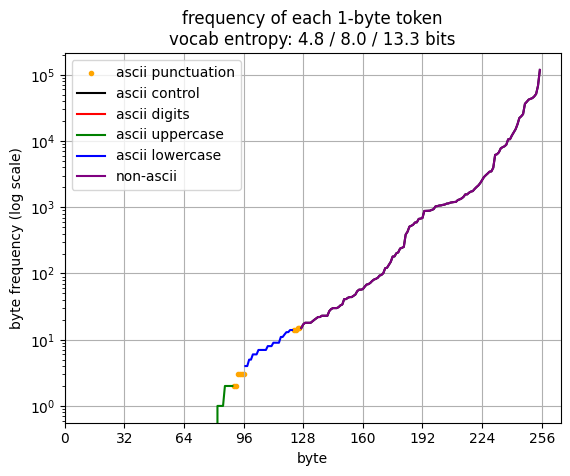

In [6]:
# ascii byte ranges
punct_idx = torch.tensor(list(range(32,48)) + list(range(58,65)) + list(range(91,97)) + list(range(123,127)))
digit_idx = torch.tensor(list(range(48,58)))
lower_idx = torch.tensor(list(range(97,123)))
upper_idx = torch.tensor(list(range(65,91)))
control_idx = torch.tensor(list(range(0,32)))
other_idx = torch.tensor(list(range(127,256)))

# plot frequencies
plt.scatter(x[punct_idx].tolist(), freqs[punct_idx].tolist(), marker='.', color='orange', label='ascii punctuation')
plt.plot(x[other_idx].tolist(), freqs[other_idx].tolist(), color='black', label='ascii control')
plt.plot(x[digit_idx].tolist(), freqs[digit_idx].tolist(), color='red', label='ascii digits')
plt.plot(x[upper_idx].tolist(), freqs[upper_idx].tolist(), color='green', label='ascii uppercase')
plt.plot(x[lower_idx].tolist(), freqs[lower_idx].tolist(), color='blue', label='ascii lowercase')
plt.plot(x[other_idx].tolist(), freqs[other_idx].tolist(), color='purple', label='non-ascii')
plt.yscale('log')
plt.title(f'frequency of each 1-byte token\nvocab entropy: {entropy(freqs):.1f} / {np.log2(256):.1f} / {max_entropy:.1f} bits')
plt.xlabel('byte')
plt.ylabel('byte frequency (log scale)')
plt.xticks(list(range(0, 257, 32))) #, rotation=90, labels=xtick_labels)
plt.grid()
plt.legend()
if env_type == 'ZMQInteractiveShell':
    plt.show()
else:
    plt.savefig('1-byte-token-frequencies.png', dpi=300)
    plt.close()

## Merge to increase entropy of the vocabulary

In [7]:
raw_freqs_cache = {t: f for t, f in vocab.items()}

raw_freqs_cache.update(get_freqs([t1+t2 for t1 in vocab for t2 in vocab], progress=True))

finding frequency of 65,536 tokens:   0%|          | 0/100 [00:00<?, ?example/s]

In [ ]:
x_time = []
y_freqs = []
ymin, ymax = 0.5, max(vocab.values())

In [15]:
def desc(f, max_h=max_entropy):
    return f"entropy: (h={entropy(f):.02f}/{np.log2(len(f)):.02f}/{max_h:.02f} bits) "


#@interactive
def show_visual_progress(x_time=x_time, y_freqs=y_freqs, vocab=vocab, max_vocab_size=max_vocab_size, max_entropy=max_entropy):
    #plt.close()
    x_time.append(time.time())
    y_freqs.append(sorted(list(vocab.values())))
    #t = time.strftime('%Y-%m-%d @ %I:%M:%S %Z', time.gmtime(x_time[-1])) # + str(t_raw % 60)
    #y = y_freqs[-1]
    #x = np.arange(len(y))
    #plt.plot(x, y, color='black')
    #plt.title(f"{t}\nentropy: {entropy(y):.01f} / {np.log2(len(y)):.01f} / {max_entropy:.01f} bits , {len(y)} tokens")
    #plt.ylabel('num occurences')
    #plt.xlabel('token id')
    #plt.yscale('log')
    ##plt.set_xscale('log')
    ##plt.set_ylim(0, max(y))
    #plt.xlim(0, max_vocab_size)
    #plt.ylim(ymin, ymax)
    #plt.show()

with tqdm(desc=f"tokens: {vocab.most_common(3)=} ", total=max_vocab_size, initial=len(vocab), unit="token", position=0, leave=True) as tokens_pb:
    with tqdm(desc=f"entropy / (log2({max_vocab_size:,} tokens) = {max_entropy:.2f} bits)", total=round(max_entropy, 2), initial=round(float(entropy(vocab)), 2), unit="bit", smoothing=1, position=1, leave=True) as entropy_best_pb:
        with tqdm(desc=f"entropy / (log2({len(vocab):,} tokens) = {np.log2(len(vocab)):.2f} bits)", total=100, initial=round(100*float(entropy(vocab) / np.log2(len(vocab))), 2), unit="percent", smoothing=2, position=1, leave=True) as entropy_curr_pb:
            show_visual_progress()
            while len(vocab) < max_vocab_size:
                median_freq = vocab.most_common()[len(vocab)//2][1]
                mergable_tokens_freqs = [(t,f) for t,f in vocab.most_common() if f >= median_freq]
                mergable_tokens, mergable_freqs = list(zip(*mergable_tokens_freqs))
                new_merged_tokens = [t1 + t2 for t1 in mergable_tokens for t2 in mergable_tokens if t1+t2 not in raw_freqs_cache]
                raw_freqs_cache.update(get_freqs(new_merged_tokens))

                no_mergable_tokens = True
                for at, af in mergable_tokens_freqs:
                    af = int(af)
                    rtfmtf = [(bt, bf, at+bt, raw_freqs_cache[at+bt]) for bt, bf in mergable_tokens_freqs if (at + bt not in vocab)]
                    ltfmtf = [(bt, bf, bt+at, raw_freqs_cache[bt+at]) for bt, bf in mergable_tokens_freqs if (bt + at not in vocab)]

                    btfmtf = rtfmtf + ltfmtf        
                    btfmtf = [(bt, bf, mt, mf) for bt, bf, mt, mf in btfmtf if mf < .87*af] #.87*af]
                    btfmtf = [(bt, bf, mt, mf) for bt, bf, mt, mf in btfmtf if mf < .87*bf] #.87*bf]
                    btfmtf = [(bt, bf, mt, mf) for bt, bf, mt, mf in btfmtf if mf > 0] #.87*bf]
                    btfmtf = [(bt, bf, mt, mf) for bt, bf, mt, mf in btfmtf if len(mt) <= max_token_length]

                    if btfmtf:
                        all_tokens, all_freqs = list(zip(*vocab.most_common()))
                        (bt, bf, mt, mf) = find_best_merge(all_tokens, all_freqs, at, *zip(*btfmtf))
                        no_mergable_tokens = False
                        break
                        
                if no_mergable_tokens:
                    print("no mergable tokens")
                    break

                vocab[mt] = int(mf)
                vocab[at] -= int(mf)
                vocab[bt] -= int(mf)
                for t, f in reversed(vocab.most_common()):
                    if (f <= 0) and (len(t) > 1):
                        del vocab[t]
                    else:
                        break
                tokens_pb.n = len(vocab)
                tokens_pb.desc = f"tokens: {vocab.most_common(3)=} "
                entropy_curr_pb.desc = f"entropy / (log2({len(vocab):,} tokens) = {np.log2(len(vocab)):.2f} bits)"
                entropy_curr_pb.n = round(100*float(entropy(vocab) / np.log2(len(vocab))) , 1)
                entropy_best_pb.n = round(float(entropy(vocab)) , 1)
                tokens_pb.refresh()
                entropy_curr_pb.refresh()
                entropy_best_pb.refresh()
                x_time.append(time.time())
                y_freqs.append(list(vocab.values()))
                show_visual_progress()


show_visual_progress()


tokens: vocab.most_common(3)=[(b'ce', 892), (b'H', 891), (b'M', 891)] :  35%|###5      | 3513/10000 [00:00<?, …

entropy / (log2(10,000 tokens) = 13.29 bits):  74%|#######3  | 9.8/13.29 [00:00<?, ?bit/s]

entropy / (log2(3,513 tokens) = 11.78 bits):  83%|########3 | 83.21/100 [00:00<?, ?percent/s]

/Users/alethea/miniconda3/envs/default/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


AttributeError: 'int' object has no attribute 'write'

## save the vocab

In [16]:

with open(vocab_file, 'w') as f:
    f.write("id, token, freq\n")
    for i, (t, fr) in enumerate(vocab.most_common()):
        f.write(f"{i}, {repr(t)}, {fr}\n")


## visualize the vocabulary development

generating data stream:   0%|          | 0/15919 [00:00<?, ?frame/s]

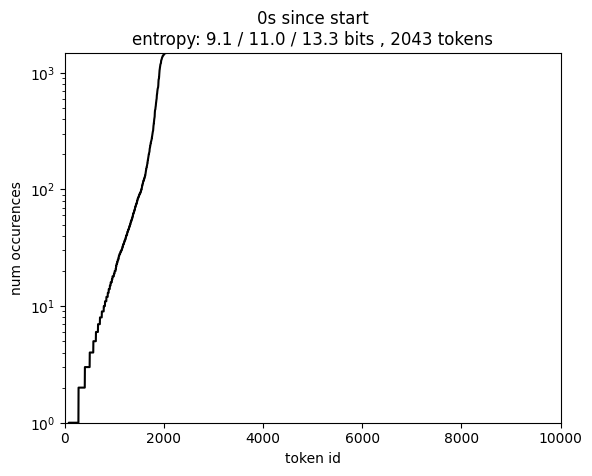

In [17]:
# https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
import matplotlib.animation as animation


class Animated(object):
    def __init__(self, x_time, y_freqs, frame_rate):
        self.x_time, self.y_freqs = x_time, y_freqs
        self.stream = self.data_stream()
        self.frame_rate = frame_rate
        self.ymin = 1
        self.ymax = max([int(f) for f in self.y_freqs[0]])
        self.t0 = x_time[0]

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=5, 
                                          save_count=len(self.x_time), blit=True) # init_func=self.update, 

    def data_stream(self):
        for t_raw, y_raw in tqdm(zip(self.x_time, self.y_freqs), total=len(self.x_time), desc="generating data stream", unit="frame", leave=True):
            #t = time.strftime('%Y-%m-%d @ %I:%M:%S %Z', time.gmtime(t_raw)) # + str(t_raw % 60)
            t = round(t_raw - self.t0)
            y = sorted(y_raw)
            x = np.arange(len(y))
            yield (t, x, y)

    def update(self, i=0):
        try:
            t, x, y = next(self.stream)
        except StopIteration:
            return []
        for line in self.ax.lines:
            line.remove()
        self.plot = self.ax.plot(x, y, color='black')
        self.ax.set_title(f"{t}s since start\nentropy: {entropy(y):.01f} / {np.log2(len(y)):.01f} / {max_entropy:.01f} bits , {len(y)} tokens")
        self.ax.set_ylabel('num occurences')
        self.ax.set_xlabel('token id')
        #self.ax.set_yscale('log')
        #self.ax.set_xscale('log')
        #self.ax.set_ylim(0, max(y))
        self.ax.set_xlim(0, max_vocab_size)
        self.ax.set_ylim(self.ymin, self.ymax)
        #plt.show()
        return self.plot


framerate = 120
a = Animated(x_time, y_freqs, framerate)
plt.show()
a.ani.save('test.mp4', fps=120, extra_args=['-vcodec', 'libx264'])
#a.ani.save('test.gif', fps=30)


In [18]:
x_time[-1] - x_time[0]

33976.092844963074

In [28]:
new_start = x_time[0] - (((len(y_freqs[-1]) - len(y_freqs[0])) / (x_time[-1] - x_time[0]) ) * (len(y_freqs[0])-365))
new_start

1694949537.380558

In [29]:
init_vocab = make_inital_vocab()


finding all 1-byte token frequencies:   0%|          | 0/100 [00:00<?, ?example/s]

In [30]:
L = [1,2,3]
L.insert(0, 'a')
L

['a', 1, 2, 3]

In [32]:
y_freqs[0] = sorted(y_freqs[0])

test_0_short_log.png


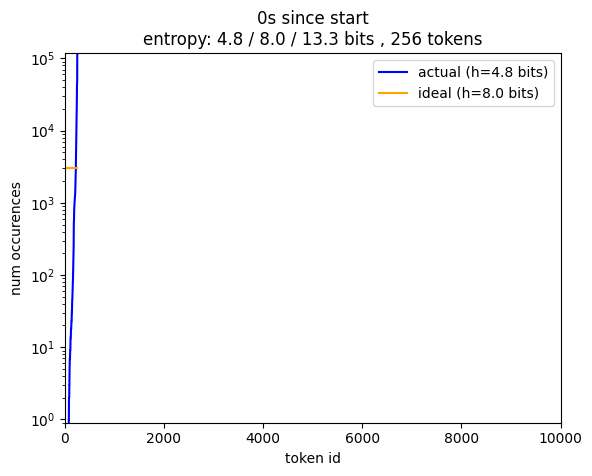

test_3184_short_log.png


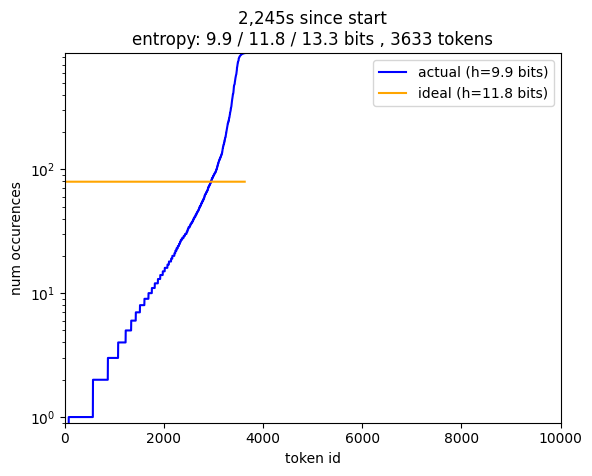

test_6368_short_log.png


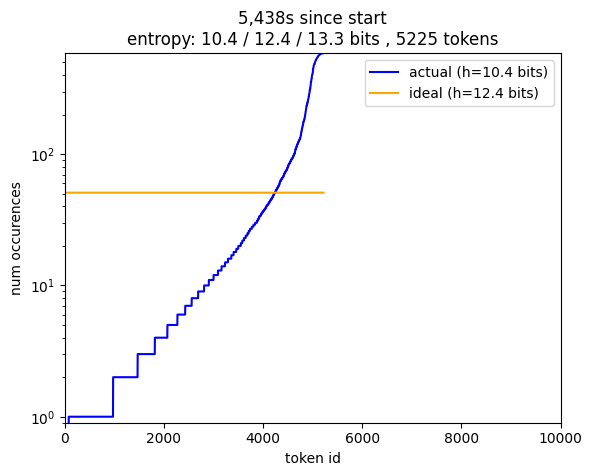

test_9552_short_log.png


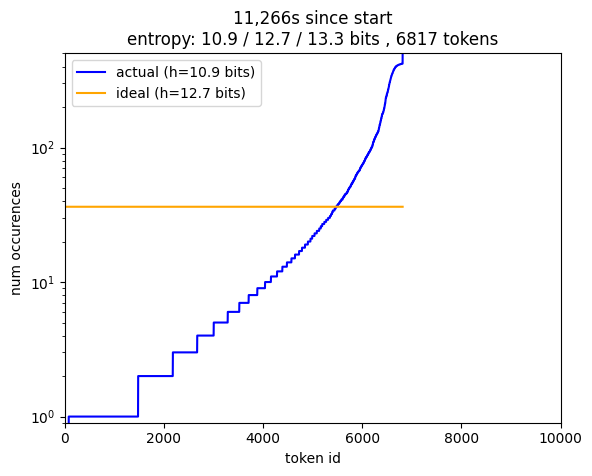

test_12736_short_log.png


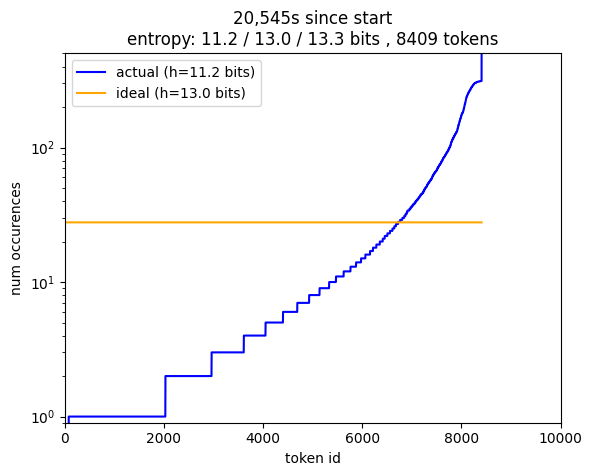

test_15919_short_log.png


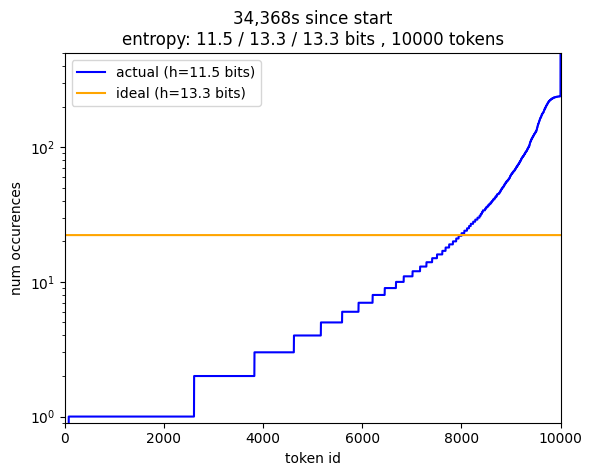

test_0_short.png


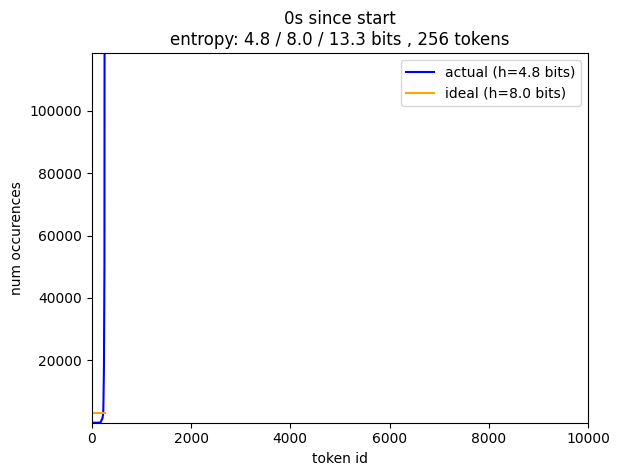

test_3184_short.png


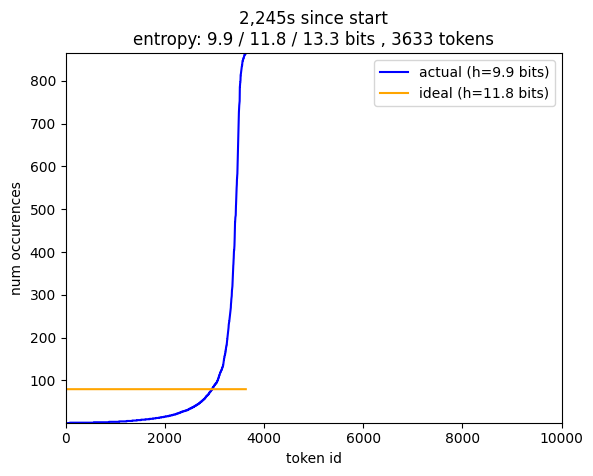

test_6368_short.png


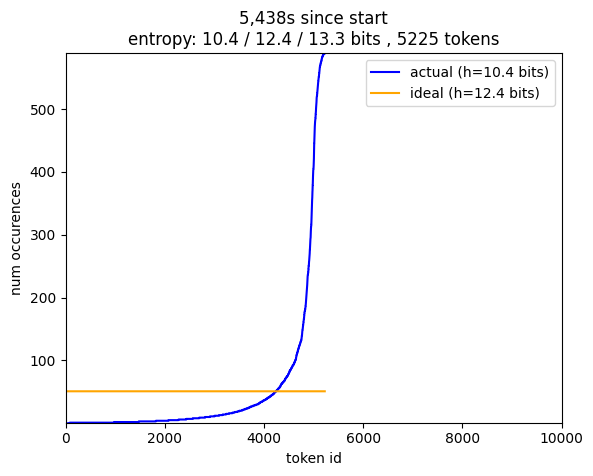

test_9552_short.png


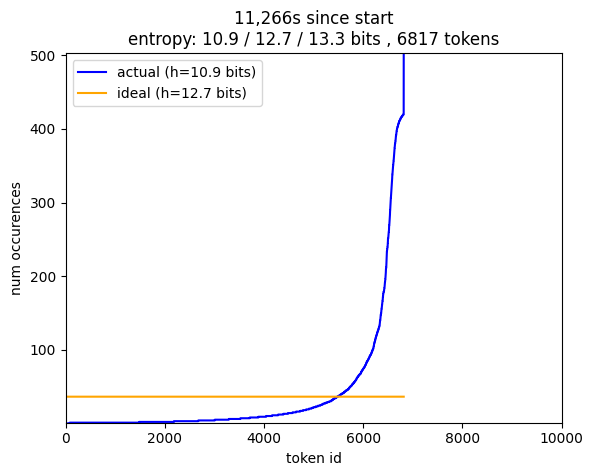

test_12736_short.png


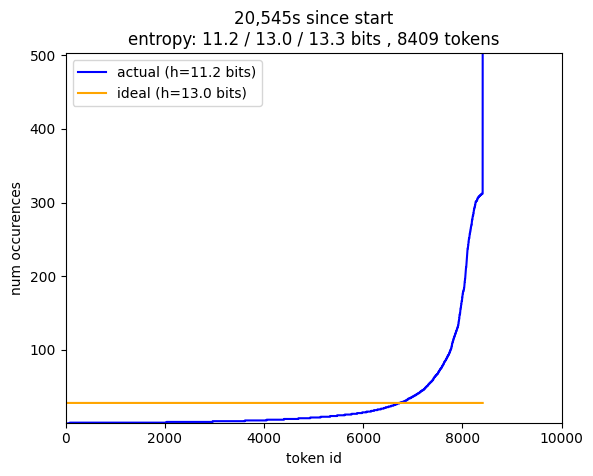

test_15919_short.png


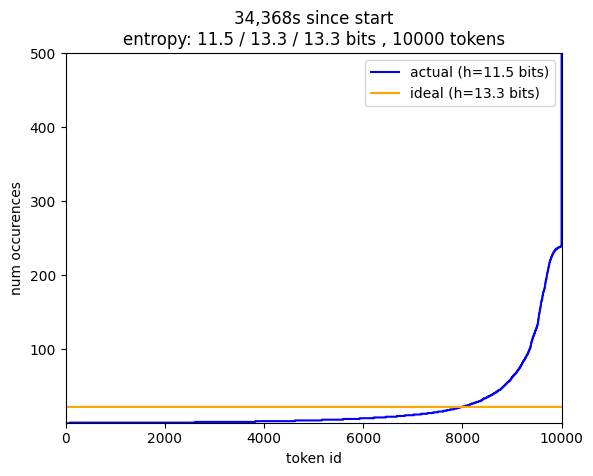

test_0_log.png


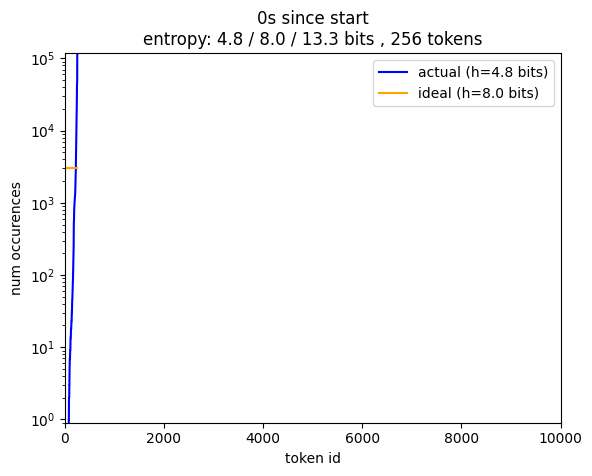

test_3184_log.png


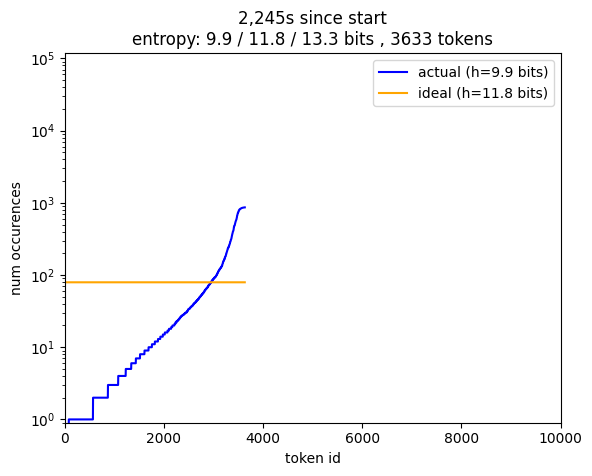

test_6368_log.png


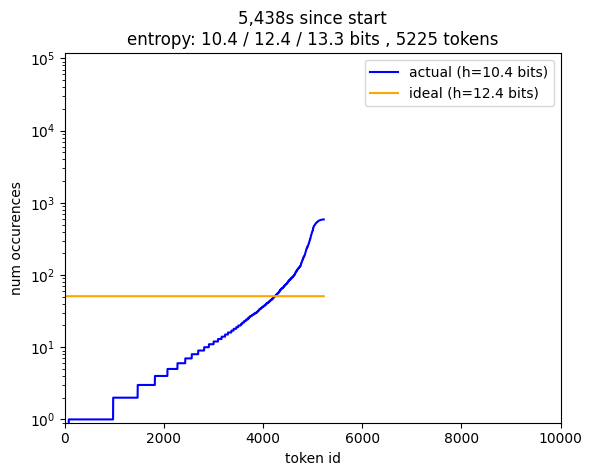

test_9552_log.png


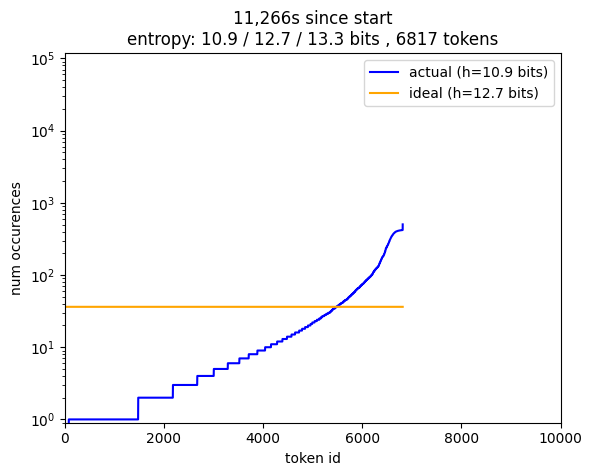

test_12736_log.png


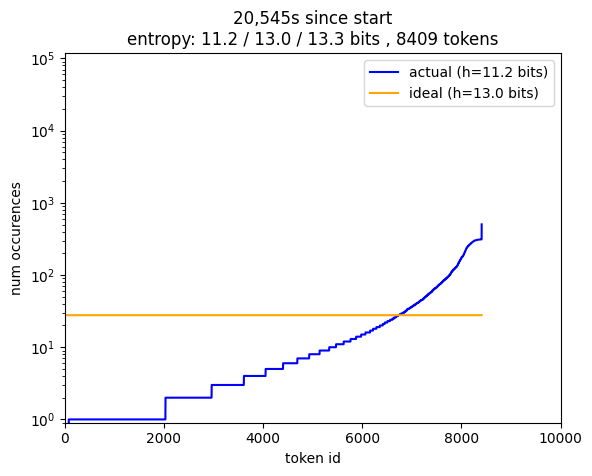

test_15919_log.png


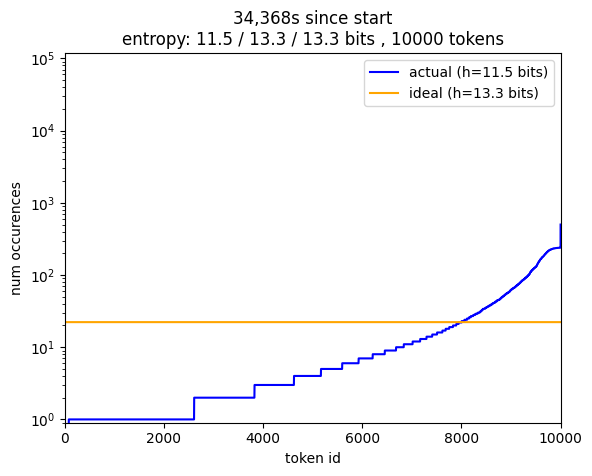

test_0.png


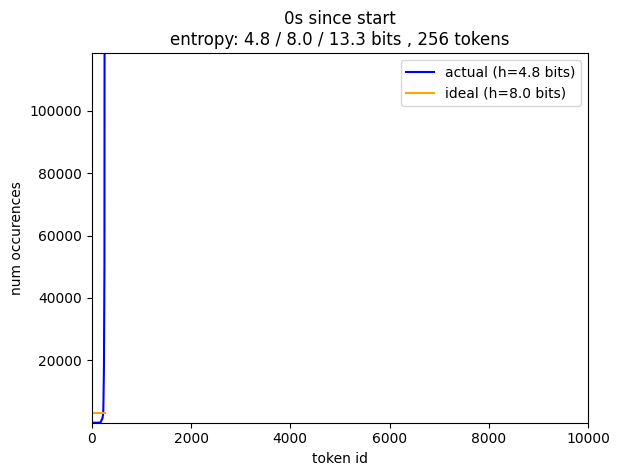

test_3184.png


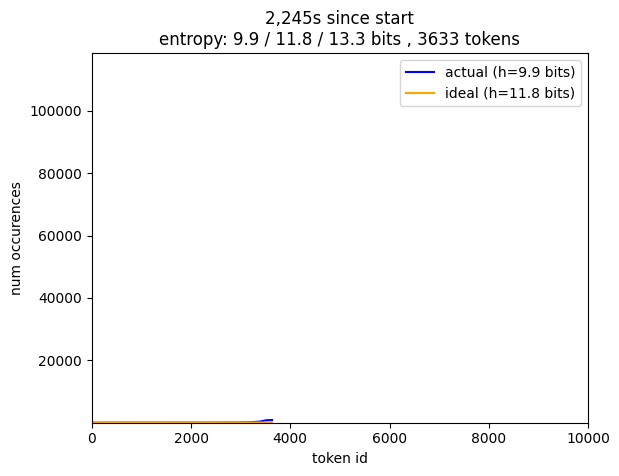

test_6368.png


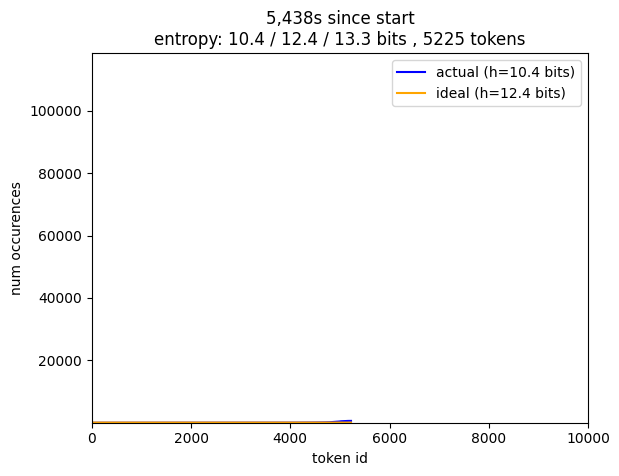

test_9552.png


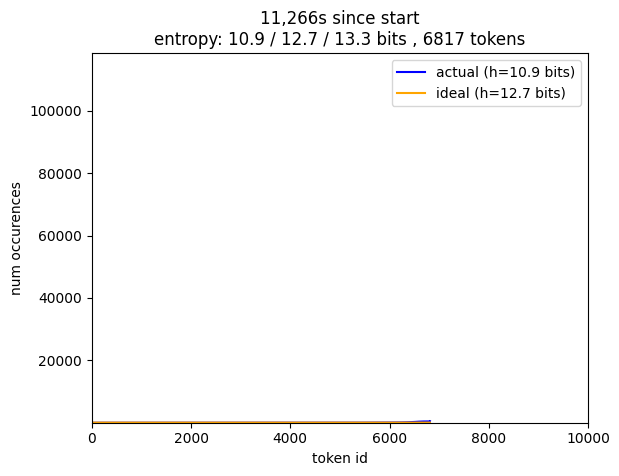

test_12736.png


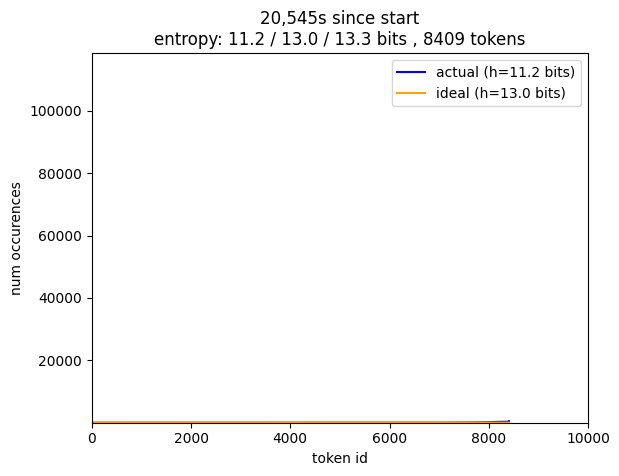

test_15919.png


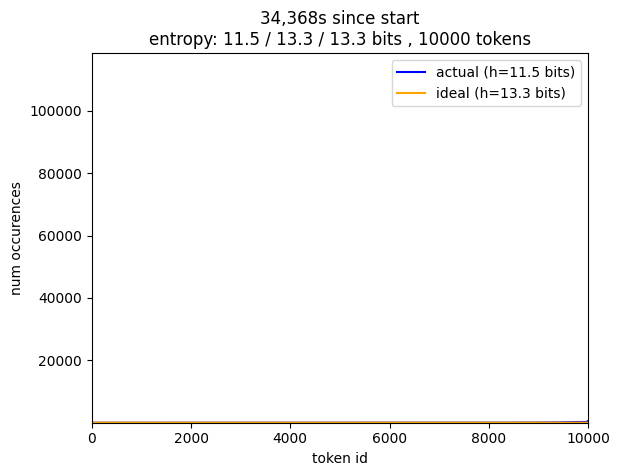

In [92]:
for short in True, False:
    for log in True, False:
        for idx in np.arange(0, len(y_freqs) + 1, len(y_freqs) // 5):
            if idx == len(y_freqs):
                idx -= 1
            xmin = 0
            xmax = max_vocab_size
            ymin = .9
            if short:
                ymax = max([int(f) for f in y_freqs[idx]])
            else:
                ymax = max(y_freqs[0])

            y = sorted(y_freqs[idx])
            x = np.arange(len(y))
            t = x_time[idx] - x_time[0]

            perf_y = [sum(y)/len(y)] * len(y)

            plt.plot(x, y, color='blue', label=f'actual (h={entropy(y):.01f} bits)')
            plt.plot(x, perf_y, color='orange', label=f'ideal (h={np.log2(len(y)):.01f} bits)')
            plt.title(f"{int(t):,}s since start\nentropy: {entropy(y):.01f} / {np.log2(len(y)):.01f} / {max_entropy:.01f} bits , {len(y)} tokens")
            plt.ylabel('num occurences')
            plt.xlabel('token id')
            if log:
                plt.yscale('log')
            #plt.set_xscale('log')
            #plt.set_ylim(0, max(y))
            plt.xlim(0, max_vocab_size)
            plt.ylim(ymin, ymax)
            # set background to white 
            plt.rcParams['axes.facecolor']='white'
            fname = f'test_{idx}{"_short" if short else ""}{"_log" if log else ""}.png'
            plt.legend()
            plt.savefig(fname, dpi=300)
            print(fname)
            plt.show()
            plt.close()


In [61]:
len(y_freqs[15919])

10000

In [66]:
np.arange(0, len(y_freqs)+1, len(y_freqs) // 5)

array([    0,  3184,  6368,  9552, 12736, 15920])

In [65]:
len(y_freqs)

15920